In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm

from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from matplotlib import pyplot as plt
import itertools

from torchvision.models import vgg16,VGG16_Weights, resnet101,ResNet101_Weights
import torch.nn as nn

In [2]:
#### Config Values ###

IMG_SHAPE = (224,224,3)
BATCH_SIZE = 128
EPOCHS = 40
SHUFFLE = True
SEED = 42
CLASSES =['cats'] # for OC-CNN
CLASSES_T =['unknown','cat','dog'] # for BoN-CNN
CLASSES_B =['wild','cat','dog'] # for Bon test
TRAIN_PATH = r"C:\Users\asiclab06\Datasets\afhq\val"
TEST_PATH = r"C:\Users\asiclab06\Datasets\afhq\train"

In [3]:
## Define Dataset

class ImageDataset(Dataset):
    def __init__(self,root,classes,target_size:tuple,shuffle=False,**kwargs):
        super().__init__()
        self.root=  root
        self.classes = classes
        self.target_size = target_size
        self.shuffle = shuffle        

        self._load_data()
        self._set_index_array()     
        self._set_shuffle()
    
        # kwargs
        self.samples = kwargs.pop('samples',None)
        if self.samples is not None:
            self._sampling_data()

    def _sampling_data(self):
        s = np.random.choice(self.__len__()-self.samples,1).item() if self.shuffle else 0
        e = self.samples
        self.data = self.data[s:e+s]
        self.label = self.label[s:e+s]

    def _load_data(self):
        self.data = []
        self.label = []

        for i,cla in enumerate(self.classes):
            sub_dir = os.path.join(self.root,cla)
            if not os.path.exists(sub_dir):
                print(f'Not found images in "{cla}" directory.')
                continue
            sub_files = os.listdir(sub_dir)
            self.data.extend([os.path.join(sub_dir,sub_file) for sub_file in sub_files])
            l=len(sub_files)
            self.label.extend([i for _ in range(l)])
            print(f'Found {l} images in "{cla}" directory.')

        self.data = np.array(self.data) 
        self.label = np.array(self.label)
        
    def _set_index_array(self):
        self.index_array = np.arange(self.__len__())
        if self.shuffle:
            self.index_array = np.random.permutation(self.__len__())

    def _set_shuffle(self):
        self.data = self.data[self.index_array]
        self.label = self.label[self.index_array]

    def __getitem__(self, index):
        """
            Return : PIL image, sparse label
        """
        x = Image.open(self.data[index]).convert('RGB')
        x = x.resize(self.target_size[:2],Image.Resampling.BILINEAR)
        

        return x, self.label[index]

    def __len__(self):
        return len(self.data)

class FaceClfDataset(ImageDataset):
    def __init__(self, root, classes, target_size: tuple, shuffle=False, transform=None, class_mode=None, **kwargs):
        super().__init__(root, classes, target_size, shuffle, **kwargs)
        # transform
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

        self.allow_class_modes =  ["categorical","sparse",None]

        if class_mode is not None:
            self.class_mode = class_mode
        else:
            self.class_mode = self.allow_class_modes[0]

    def _class_mode(self,y):
        if self.class_mode == self.allow_class_modes[0]:
            return self._to_categorical_class(y)
        elif self.class_mode == self.allow_class_modes[1]:
            return torch.tensor(y,dtype=torch.long)

    def _to_categorical_class(self,y):
        temp = torch.zeros((len(self.classes),),dtype=torch.long)
        temp[y] = 1
        return temp 

    def categorical2sparse(y:torch.Tensor):
        return torch.argmax(y,1)

    def __getitem__(self, index):
        x,y = super().__getitem__(index)
        return self.transform(x),self._class_mode(y)

    def __len__(self):
        return super().__len__()    


In [4]:
## train, val set
train_dataset = FaceClfDataset(TRAIN_PATH,CLASSES_T,(IMG_SHAPE),SHUFFLE,class_mode='categorical')
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

test_dataset = FaceClfDataset(TEST_PATH,CLASSES_B,(IMG_SHAPE),False,class_mode='categorical')
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)


Not found images in "unknown" directory.
Found 500 images in "cat" directory.
Found 500 images in "dog" directory.
Found 4738 images in "wild" directory.
Found 5153 images in "cat" directory.
Found 4739 images in "dog" directory.


In [5]:
## utills 

def wrap_generator(generator):
    while True:
        x,y = next(iter(generator))
        zeros = torch.zeros_like(y) + torch.Tensor([1.,0.,0.]) # add fake label
        y = torch.concat([y,zeros], axis=0)
        yield x,y

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,cm_proba=True):
    if cm_proba:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

def plot_confusion_matrix_detail(cm,classes):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_confusion_matrix(cm,classes)
    plt.subplot(122)
    plot_confusion_matrix(cm,classes,cm_proba=False)
    
def sample_from_derectory(base_path=TEST_PATH,labels=CLASSES_T): # func only this file
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    samples = []
    for ax in axes.ravel():
        label = np.random.choice(os.listdir(base_path))
        i = np.where(np.array(labels)==label)[0]
        img = np.random.choice(os.listdir(os.path.join(base_path, label)))
        img = Image.open(os.path.join(base_path, label) + "/" + img) # os.path.join
        img = img.resize(IMG_SHAPE[:2],resample=Image.Resampling.NEAREST)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label+" "+str(i))  
        samples.append(np.array(img))
    
    return np.array(samples)

def plot_result(samples,preds,true_label=None,labels=CLASSES_B):
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    
    for i,ax in enumerate(axes.ravel()):
        label = labels[preds[i]]
        l = preds[i]
        img = Image.fromarray(samples[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("P : "+label+" "+str(l))  



In [10]:
## models 

def get_vgg16(n_classes,device = torch.device('cuda:0')):
    vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in vgg.parameters():
        param.requires_grad = False

    # clf.add_module(str(clf.__len__()),
    #     nn.Linear(in_features=4096, out_features=n_classes, bias=True))
    clf = nn.Sequential(
        nn.Linear(in_features=4096, out_features=512, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=True),
    )
    return nn.Sequential(vgg.features,nn.Flatten(),vgg.classifier[:1]).to(device),clf.to(device)

def get_resnet101(n_classes,device = torch.device('cuda:0')):
    resnet = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    for param in resnet.parameters():
        param.requires_grad = False

    clf = nn.Sequential(
        nn.Linear(in_features=2048, out_features=512, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=True),
    )
    return nn.Sequential(*[_ for _ in resnet.children()][:-1],nn.Flatten()).to(device),clf.to(device)

class OCCNN(nn.Module):
    def __init__(self,n_classes,backbone:str,device):
        """
        Args: 
            n_classes : trainning classes number. ex. ['cat','dog'] => n_classes = 2
            backbone : current allow model [vgg16, resnet101] 
        """
        super().__init__()
        
        self.device = device
        self.n_classes = n_classes
        self.backbone, self.clf = self._get_backbone(backbone)

        self.inm = nn.InstanceNorm1d(1)
        self.relu = nn.ReLU()

        if self.device == torch.device('cuda:0'):
            self.cuda()
        else:
            self.cpu()
        
        a = next(self.backbone.parameters()).device
        print(f"Model is on device: {a}")
    
    def _get_backbone(self,b):
        return eval(f'get_{b}(self.n_classes,"{self.device}")')

    def forward(self,x):
        x = self.backbone(x)

        if self.training:
            unk_vector = torch.normal(0.,0.01,x.shape,device=self.device)
            x = self.inm(x)
            x = torch.vstack([x,unk_vector])
            x = self.relu(x)
        else :
            x = x

        x = self.clf(x)

        return x

    def fit(self,
        train_generator,
        epochs,
        lr,
        device,
        val_generator=None
        ):
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(self.clf.parameters(),)
        
        for ep in range(epochs):
            train_loss = 0.
            self.train()
            i=0
            for x,y in tqdm(train_generator):
                zeros = torch.zeros_like(y) + torch.Tensor([1.,0.,0.]) # add fake label
                y = torch.concat([y,zeros], axis=0)
                x = x.to(device)
                y = y.to(device)

                optim.zero_grad()
                pred = self.forward(x)
                loss = criterion(pred,y)
                loss.backward()
                optim.step()
                
                train_loss += loss.item()
                i += 1

            print(train_loss/i)


    def predict(self,test_generator):
        preds = torch.Tensor([],device=self.device)
        for x,y in test_generator:
            x = x.to(self.device)
            y = y.to(self.device)

            pred = self.forward(x)

            preds = torch.concat(preds,pred)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
c = OCCNN(2,'vgg16',device)


Model is on device: cuda:0


In [7]:
## BoN train

train_dataset = FaceClfDataset(r"data\train",['unkown','cats','dogs'],(IMG_SHAPE),SHUFFLE,class_mode='categorical')
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

test_dataset = FaceClfDataset(r'data\test',['wild','cats','dogs'],(IMG_SHAPE),False,class_mode='categorical')
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)

c.fit(train_loader,40,1e-4,device)


Not found images in "unkown" directory.
Found 300 images in "cats" directory.
Found 300 images in "dogs" directory.
Found 500 images in "wild" directory.
Found 1000 images in "cats" directory.
Found 1000 images in "dogs" directory.


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


0.9480209469795227


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


0.8441077589988708


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


0.8283810257911682


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.8186183452606202


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.8037240982055665


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.786027479171753


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.7569929122924804


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.7159672260284424


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.66297367811203


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.6163149237632751


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5819099545478821


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


0.5650889039039612


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5588160395622254


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


0.5558948278427124


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5556391954421998


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5548354029655457


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


0.5545990705490113


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.5544275760650634


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5539322257041931


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


0.5537723779678345


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5536494135856629


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.5539134979248047


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.5538500189781189


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5534436345100403


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5537566781044007


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5533697247505188


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


0.5533401727676391


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.5533117413520813


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5532957792282105


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5536253333091736


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5532683968544007


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5536080718040466


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.553602933883667


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.553596019744873


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5532300353050232


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


0.5532220125198364


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.5532137751579285


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


0.5535562038421631


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


0.553188419342041


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

0.5531770944595337


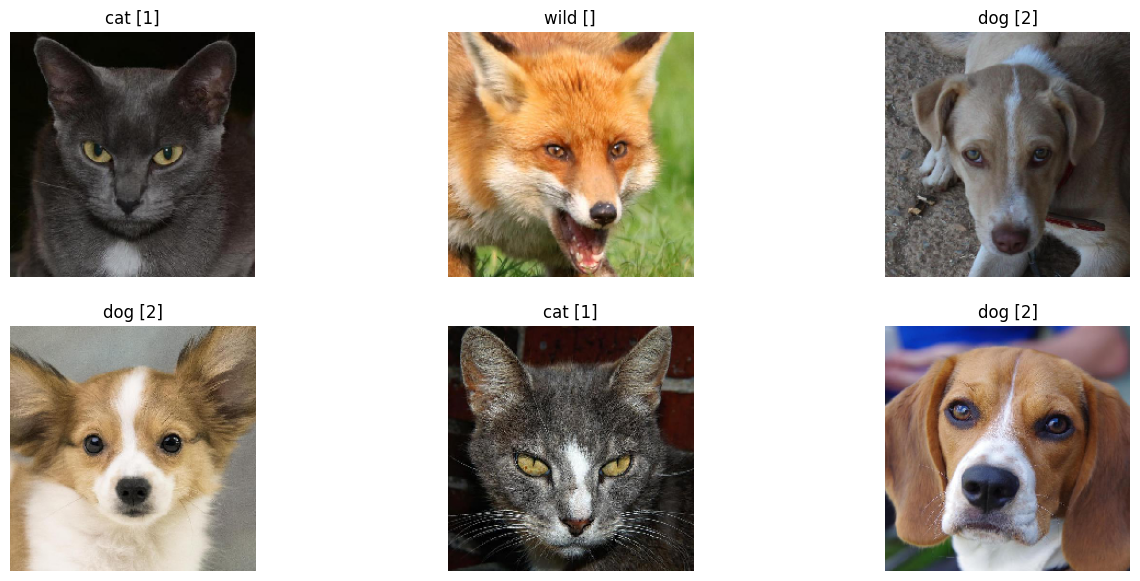

In [8]:
samples = sample_from_derectory()

In [9]:
c.cuda()
c.eval()
inp = torch.from_numpy(samples/255)
inp = inp.permute(0,3,1,2).float().to('cuda:0')
preds = torch.softmax(c(inp),1)
print(preds)
preds = torch.argmax(preds,1)
preds

tensor([[0.0000e+00, 1.0000e+00, 1.4013e-45],
        [0.0000e+00, 9.6500e-01, 3.5000e-02],
        [0.0000e+00, 2.9762e-19, 1.0000e+00],
        [0.0000e+00, 4.0852e-05, 9.9996e-01],
        [0.0000e+00, 1.0000e+00, 1.9855e-40],
        [0.0000e+00, 1.9431e-32, 1.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


tensor([1, 1, 2, 2, 1, 2], device='cuda:0')